In [1]:
import os
from operator import itemgetter
from warnings import filterwarnings

import torch

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy


torch.set_default_tensor_type(torch.cuda.FloatTensor)


filterwarnings('ignore', message='indexing past lexsort depth may impact performance.')
filterwarnings('ignore', module='torch.nn.modules.lazy')
filterwarnings('ignore', message='Named tensors')
filterwarnings('ignore', module='pytorch_lightning.trainer.data_loading',
               message='The dataloader, train_dataloader, does not have many workers')

In [2]:
from libsimplesn import SimpleSN

simplesn = SimpleSN(survey='pantheon-g10', datatype='mphotoz', N=1_000, suffix=0, version=0)
config = simplesn.config('simplesn-marginal.yaml', gen=True, latent=True, collapse=False)
nre = config.lightning_nre

LATENT_PARAMS = 'M0',

#### Enact constraints

In [3]:
from libplotting import get_priors

nre.dataset_config.kwargs['ranges'].update({
    key: itemgetter('lower', 'upper')(val)
    for key, val in simplesn.hdi_bounds[(simplesn.datatype, simplesn.N)].to_dict().items()
})

priors = get_priors(set(nre.param_names) - set(LATENT_PARAMS), nre.dataset.dataset)
ranges = {key: (prior.support.lower_bound, prior.support.upper_bound) for key, prior in priors.items()}
ranges

/usr/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.0.5-build-libtorrent-rasterbar-src-libtorrent-rasterbar-2.0.5-bindings-python is an invalid version and will not be supported in a future release
  warnings.warn(


{'Om0': (0.019863375192098465, 0.5929119150771285),
 'Ode0': (0.17853226005090528, 1.2018271156589926),
 'alpha': (0.09822263026281111, 0.17409884718253238),
 'beta': (2.7031631682328685, 3.4784610383293972),
 'mean_M0': (-19.58042623202739, -19.421050543521414),
 'sigma_res': (tensor(0.0422), tensor(0.1394)),
 'mean_x1': (-0.22284100129344814, 0.20369263953716898),
 'log10_R_x1': (-0.06668264626340684, 0.07618668977774774),
 'mean_c': (-0.023116221852128076, 0.0235441744933571),
 'log10_R_c': (-1.0599180896655265, -0.9319794633306818)}

#### Define network

In [4]:
from torch.nn import Module
import attr
from torch import nn, Tensor

from clipppy.commands.lightning.config.schedulers import StepLR
from clipppy.commands.lightning.hyper import Scheduler
from clipppy.commands.lightning import hyper as h
from clipppy.commands.nre import MultiNRETail, WhiteningHead, WhiteningTail
from clipppy.utils.nn import _empty_module, USequential
from phytorch.utils.broadcast import broadcast_cat


MAX_BATCH = 32 if simplesn.N > 50_000 else 64
STRUCTURE_NAME = 'latent'
HPARAMS_NAME = 'highlr'

hp = h.Hyperparams(
    h.Structure(
        head=h.BaseHParams(
            pre=h.MLP(3, 128, 32),
            summary=h.BaseHParams(
                dropout=0.5,
                net=h.Linear(256)
            )
        ),
        tail=h.BaseHParams(
            cosmo=h.Tail(
                thead=h.MLP(2, 256),
                net=h.OMLP(3, 256)
            ),
            other=h.Tail(
                thead=h.MLP(2, 128),
                net=h.OMLP(3, 128)
            ),
            latent=h.BaseHParams(
                ihead=h.MLP(3, 128, 16),
                net=h.OMLP(3, 128)
            )
        )
    ),
    h.Training(
        1e-3, 64,
        Scheduler(StepLR, step_size=2000, gamma=0.5)
        if 'step' in HPARAMS_NAME else None
    )
)

@attr.s(auto_attribs=True, eq=False)
class IUWhiteningTail(WhiteningTail):
    ihead: Module = attr.ib(default=_empty_module)
    shead: Module = attr.ib(default=_empty_module)

    def forward(self, theta: Tensor, x: tuple[Tensor, Tensor]) -> Tensor:
        return self.net(broadcast_cat((
            # self.ihead(torch.linspace(-1, 1, theta.shape[-1]).unsqueeze(-1)),
            self.thead(theta),
            self.xhead(x[0]),
            self.shead(x[1].unsqueeze(-2))
        ), -1)).squeeze(-1)


nre.head = WhiteningHead(head=nn.Sequential(
    nn.Unflatten(-1, (-1, 3)),
    hp.structure.head.pre.make(),
    USequential(
        nn.Flatten(-2),
        nn.Dropout(hp.structure.head.summary.dropout) if hp.structure.head.summary.dropout else _empty_module,
        hp.structure.head.summary.net.make())
), event_dims={'data': 2})
nre.tail = MultiNRETail(tails={
    'M0': IUWhiteningTail(
        ihead=hp.structure.tail.latent.ihead.make(),
        net=hp.structure.tail.latent.net.make()
    ),
})

nre.just_save_hyperparameters(dict(hp.collapse()))

#### Define learning

In [5]:
# Learning rate
nre.lr = nre.hparams['training/lr']

# Batch size
assert (nre.hparams['training/batch_size'] < MAX_BATCH
        or not nre.hparams['training/batch_size'] % MAX_BATCH)
memory_batch_size = min(nre.hparams['training/batch_size'], MAX_BATCH)
accumulate_grad_batches = nre.hparams['training/batch_size'] // memory_batch_size
nre.dataset_config.kwargs['batch_size'] = memory_batch_size

# Scheduler
if hp.training.scheduler:
    nre.scheduler_config = hp.training.scheduler.make()

In [6]:
from clipppy.commands.lightning.patches import LearningRateMonitor, ModelCheckpoint, TensorBoardLogger, Trainer


BASE_LOGDIR = 'lightning_logs'
CHECKPOINT_EVERY = 2000
VALIDATE_EVERY = 500
VALIDATE_SAMPLES = 1024


name = os.path.join(simplesn.basedata_prefix, STRUCTURE_NAME, HPARAMS_NAME)
# validator = MultiNREValidator(VALIDATE_SAMPLES // MAX_BATCH, MAX_BATCH, nre.dataset, nrepper())

trainer = Trainer(
    gpus=1, max_epochs=-1,
    max_steps=10000,
    logger=TensorBoardLogger(BASE_LOGDIR, name),
    callbacks=[
        # MultiValidationCallback(VALIDATE_EVERY, nre, validator),
        # MultiPosteriorCallback(VALIDATE_EVERY, nre, validator.nrep, simplesn.data),
        LearningRateMonitor(),
        ModelCheckpoint(every_n_train_steps=CHECKPOINT_EVERY)
    ],
    accumulate_grad_batches=accumulate_grad_batches
)
trainer.fit(nre, nre.training_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: 0it [00:00, ?it/s]

#### Evaluate posterior

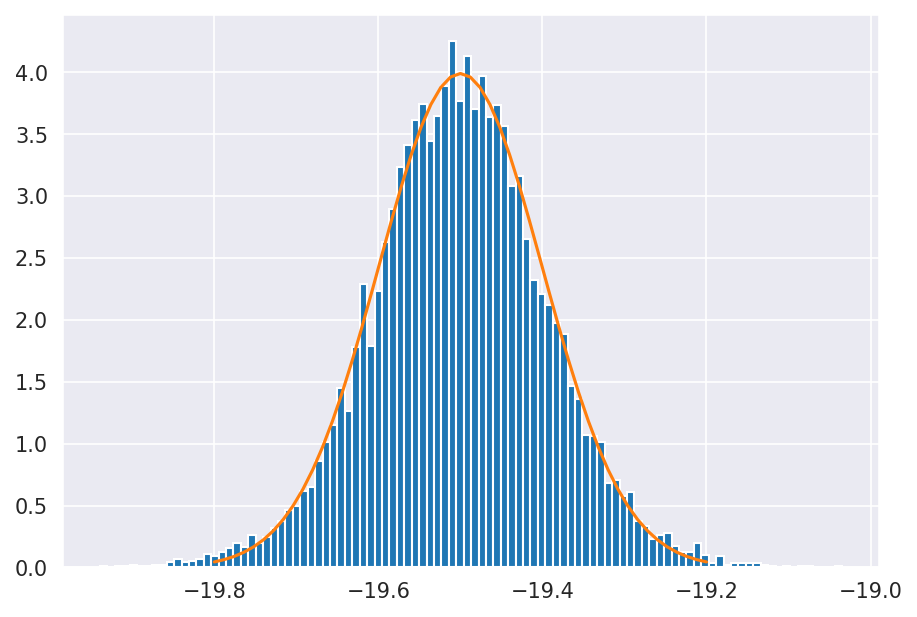

In [19]:
import pyro

from matplotlib import pyplot as plt

from clipppy.distributions.conundis import ConstrainingMessenger
from clipppy.stochastic import find_sampler
from clipppy.utils.messengers import CollectSitesMessenger


TRENDKWARGS = dict(color='k', ls='--', zorder=-0.5)


with CollectSitesMessenger('M0') as prior_samples, pyro.plate('plate', 10000),  ConstrainingMessenger(ranges=ranges):
    find_sampler(config._model, 'M0')()
prior_samples = {key: prior_samples[key]['value'] for key in LATENT_PARAMS}

plt.hist(prior_samples['M0'][:, 0].numpy(), bins=100, density=True)
plt.plot(_:=torch.linspace(-19.8, -19.2, 51), torch.distributions.Normal(-19.5, 0.1).log_prob(_).exp_())

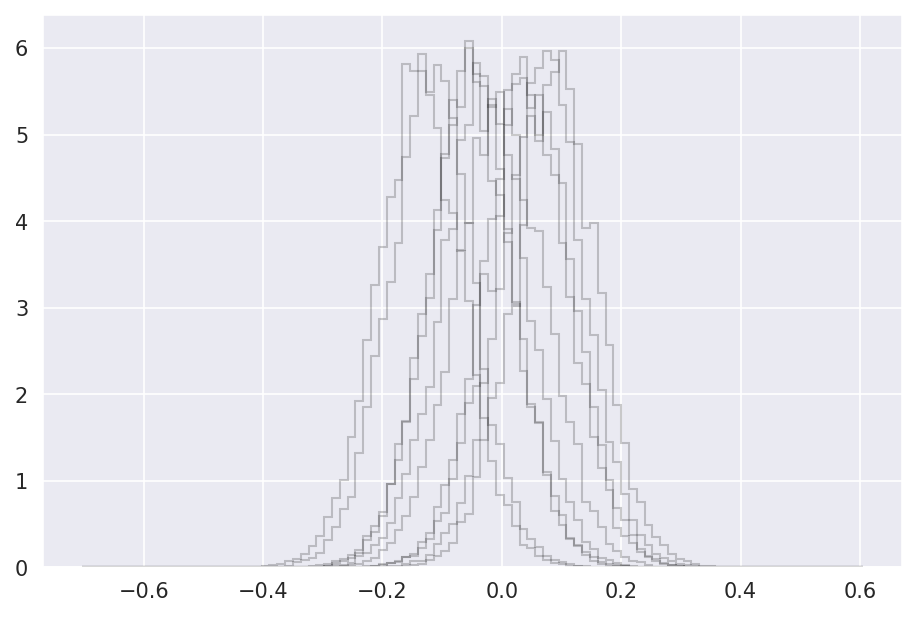

In [20]:
obs = {key: simplesn.data[key] for key in nre.obs_names}

nre.cuda()
nre.head.eval(), nre.tail.eval()
with torch.no_grad():
    ratios = torch.cat([nre.tail(*nre.head({'M0': val}, obs))['M0'].exp_() for val in prior_samples['M0'].split(100, dim=0)], 0)
weights = ratios / ratios.sum(0)

post_mean = (weights * prior_samples['M0']).sum(0)
post_std = ((weights * prior_samples['M0']**2).sum(0) - post_mean**2)**0.5

mask = slice(None), slice(10)
plt.hist(
    (prior_samples['M0'] - simplesn.data['M0'])[mask].numpy(),
    weights=ratios[mask].numpy(), histtype='step', bins=100, density=True,
    alpha=0.2, color=10*['k']
);

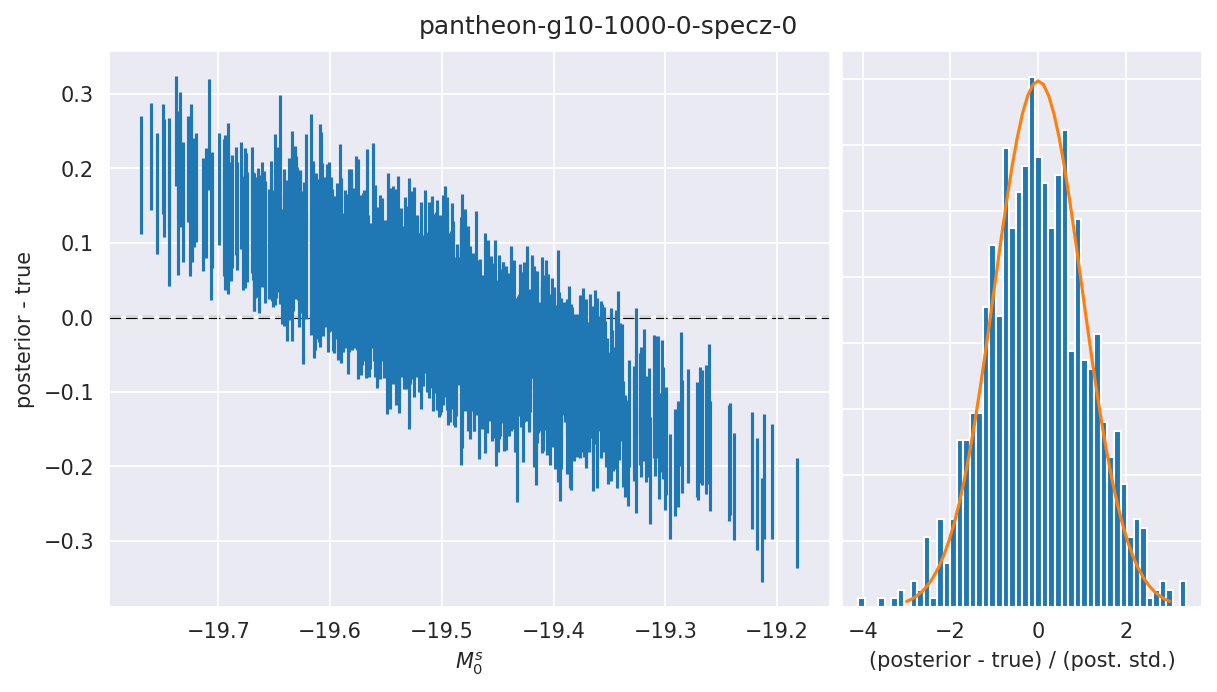

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4.5), gridspec_kw=dict(width_ratios=(2, 1)))

truth = simplesn.data['M0']
axs[0].axhline(0, **TRENDKWARGS)
axs[0].errorbar(truth, post_mean - truth, yerr=post_std, ls='none')

axs[1].hist(((post_mean - truth) / post_std).numpy(), bins=50, density=True)
axs[1].plot(_:=torch.linspace(-3, 3, 51), torch.distributions.Normal(0, 1).log_prob(_).exp_())

axs[1].set_yticklabels([])
axs[0].set_xlabel('$M_0^s$')
axs[0].set_ylabel('posterior - true')
axs[1].set_xlabel('(posterior - true) / (post. std.)')
fig.suptitle(simplesn.data_prefix);

In [22]:
emcee_loc, emcee_var = simplesn.emcee_latent
emcee_mean = emcee_loc[:, 0] - (simplesn.data['m'] - simplesn.data['M'])
emcee_std = emcee_var[:, 0, 0]**0.5

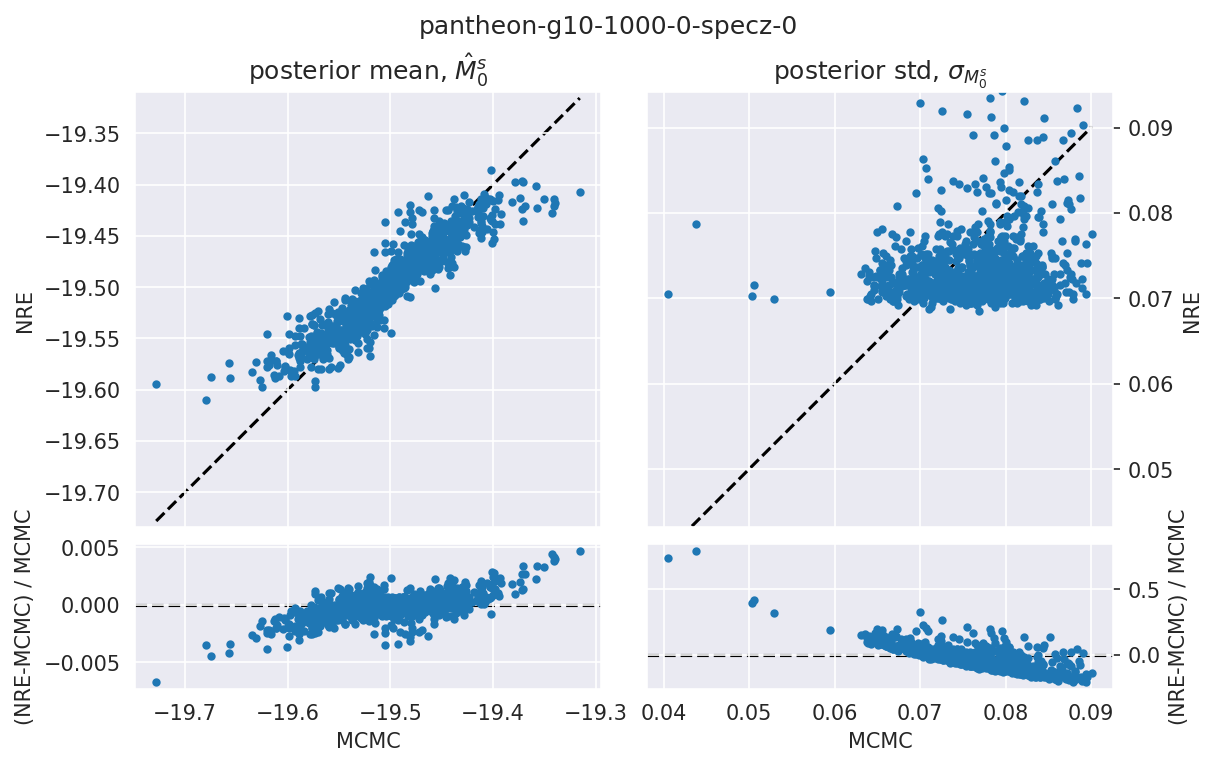

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(3, 1)), sharex='col')


for ax, (us, them, title) in zip(axs.T, (
        (post_mean, emcee_mean, r'posterior mean, $\hat{M}_0^s$'),
        (post_std, emcee_std, r'posterior std, $\sigma_{M_0^s}$'))):
    ax[0].plot(*2*(them.aminmax(),), **TRENDKWARGS)
    ax[0].plot(them, us, '.')

    ax[1].axhline(0, **TRENDKWARGS)
    ax[1].plot(them, (us-them)/them, '.')

    ax[0].set_aspect('equal', adjustable='datalim')
    ax[0].set_title(title)
    ax[1].set_xlabel('MCMC')
    ax[0].set_ylabel('NRE')
    ax[1].set_ylabel('(NRE-MCMC) / MCMC')

for ax in axs[:, -1]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

fig.suptitle(simplesn.data_prefix);

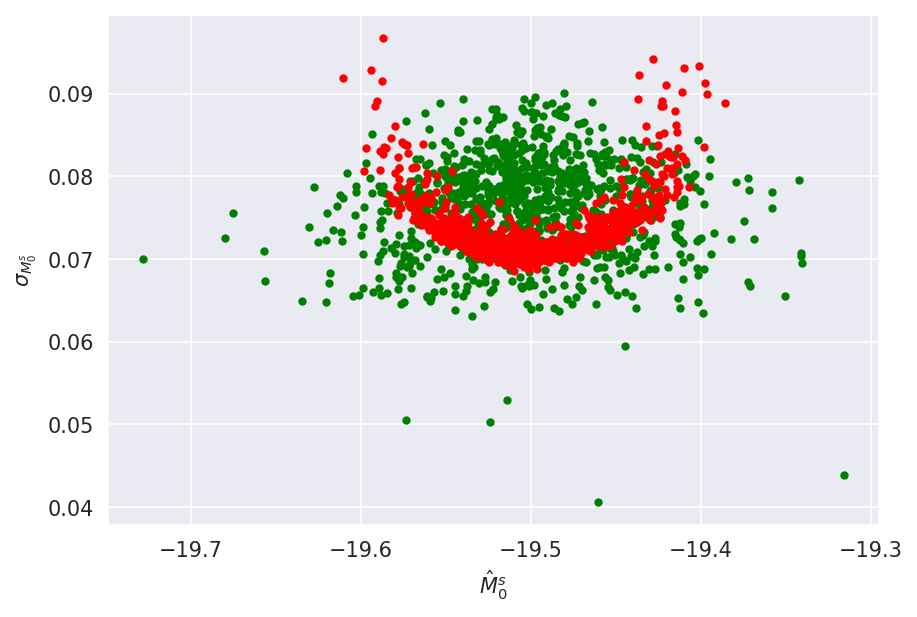

In [24]:
plt.plot(emcee_mean, emcee_std, 'g.')
plt.plot(post_mean, post_std, 'r.')
plt.xlabel(r'$\hat{M}_0^s$')
plt.ylabel(r'$\sigma_{M_0^s}$');